In [ ]:
# Importe de librerias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score

In [231]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [232]:
# Input variables:
#    # bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
#                                        "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")
#    # related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)
#    # other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#   Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [233]:
display(df.head(5))
display(df.dtypes)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [241]:
target_col = "y"
NUM_COLS = ["age","balance","day","duration","campaign","pdays","previous"
]

CAT_COLS = [
"job","marital","education","default","housing","loan","contact","month","poutcome"
]

In [ ]:
# Se crea esta función para validar que los datos que se recibiran a 
# futuro, están en linea con las variables de entreno o de estudio, asi mismo si existen nulos o no, y si es así revisar los casos puntales 
# Se transforma la variable Y categorica a numerical, se puede hacer porque es una variable ordinal
def validacion(data_frame):
    required = set([target_col] + NUM_COLS + CAT_COLS)
    if required != set(data_frame.columns):
        faltante = set(data_frame.columns).difference(required)
        sobrante = required.difference(set(data_frame.columns))
        raise ValueError(f"Col faltante: {faltante} , col sobrantes {sobrante}")
    else:
        print("Columnas coinciden: OK")

        
    nulos = data_frame.isnull().sum()
    columnas_con_nulos = nulos[nulos > 0]

    if not columnas_con_nulos.empty:
        raise ValueError(f"Col null: (columnas_con_nulos)")
    else:
        print("No existen columnas con Null: OK")

    data_frame["y"] = (data_frame["y"].astype(str).str.lower() == "yes").astype(int)


In [ ]:
def graph(data_frame):

    num_df = data_frame.select_dtypes(include=np.number)
    cols = num_df.columns
    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(num_df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribución de {col}")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    corr = num_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        annot=True,
        cmap="coolwarm",
        center=0,
        fmt=".2f",
        linewidths=0.5)
    plt.title("Mapa de calor de correlaciones", fontsize=14, pad=12)
    plt.show()



In [236]:
def percent_box(data_frame):
    num_df = data_frame.select_dtypes(include=np.number)
    cols = num_df.columns
    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.violinplot(y=data_frame[col], ax=axes[i], inner=None, color="lightgray")
        sns.boxplot(y=data_frame[col], ax=axes[i], width=0.2, color="skyblue")
        axes[i].set_title(f"{col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    
    return plt.show()

In [245]:
def resumen_por_categoria(data_frame, cat_cols, target='y'):
    for col in cat_cols:
        t = (
            data_frame
            .groupby(col)[target]
            .agg(
                y_1=lambda x: (x == 1).sum(),
                y_0=lambda x: (x == 0).sum(),
                total='size',
                rate='mean'
            )
            .sort_values('total', ascending=False)
        )
        display(t)


In [246]:
resumen_por_categoria(df,cat_cols)

,y_1,y_0,total,rate
job,,,,
blue-collar,708,9024,9732,0.073
management,1301,8157,9458,0.138
technician,840,6757,7597,0.111
admin.,631,4540,5171,0.122
services,369,3785,4154,0.089
retired,516,1748,2264,0.228
self-employed,187,1392,1579,0.118
entrepreneur,123,1364,1487,0.083
unemployed,202,1101,1303,0.155


,y_1,y_0,total,rate
marital,,,,
married,2755,24459,27214,0.101
single,1912,10878,12790,0.149
divorced,622,4585,5207,0.119


,y_1,y_0,total,rate
education,,,,
secondary,2450,20752,23202,0.106
tertiary,1996,11305,13301,0.150
primary,591,6260,6851,0.086
unknown,252,1605,1857,0.136


,y_1,y_0,total,rate
default,,,,
no,5237,39159,44396,0.118
yes,52,763,815,0.064


,y_1,y_0,total,rate
housing,,,,
yes,1935,23195,25130,0.077
no,3354,16727,20081,0.167


,y_1,y_0,total,rate
loan,,,,
no,4805,33162,37967,0.127
yes,484,6760,7244,0.067


,y_1,y_0,total,rate
contact,,,,
cellular,4369,24916,29285,0.149
unknown,530,12490,13020,0.041
telephone,390,2516,2906,0.134


,y_1,y_0,total,rate
month,,,,
may,925,12841,13766,0.067
jul,627,6268,6895,0.091
aug,688,5559,6247,0.110
jun,546,4795,5341,0.102
nov,403,3567,3970,0.102
apr,577,2355,2932,0.197
feb,441,2208,2649,0.166
jan,142,1261,1403,0.101
oct,323,415,738,0.438


,y_1,y_0,total,rate
poutcome,,,,
unknown,3386,33573,36959,0.092
failure,618,4283,4901,0.126
other,307,1533,1840,0.167
success,978,533,1511,0.647


In [237]:
validacion(df)

Columnas coinciden: OK
No existen columnas con Null: OK


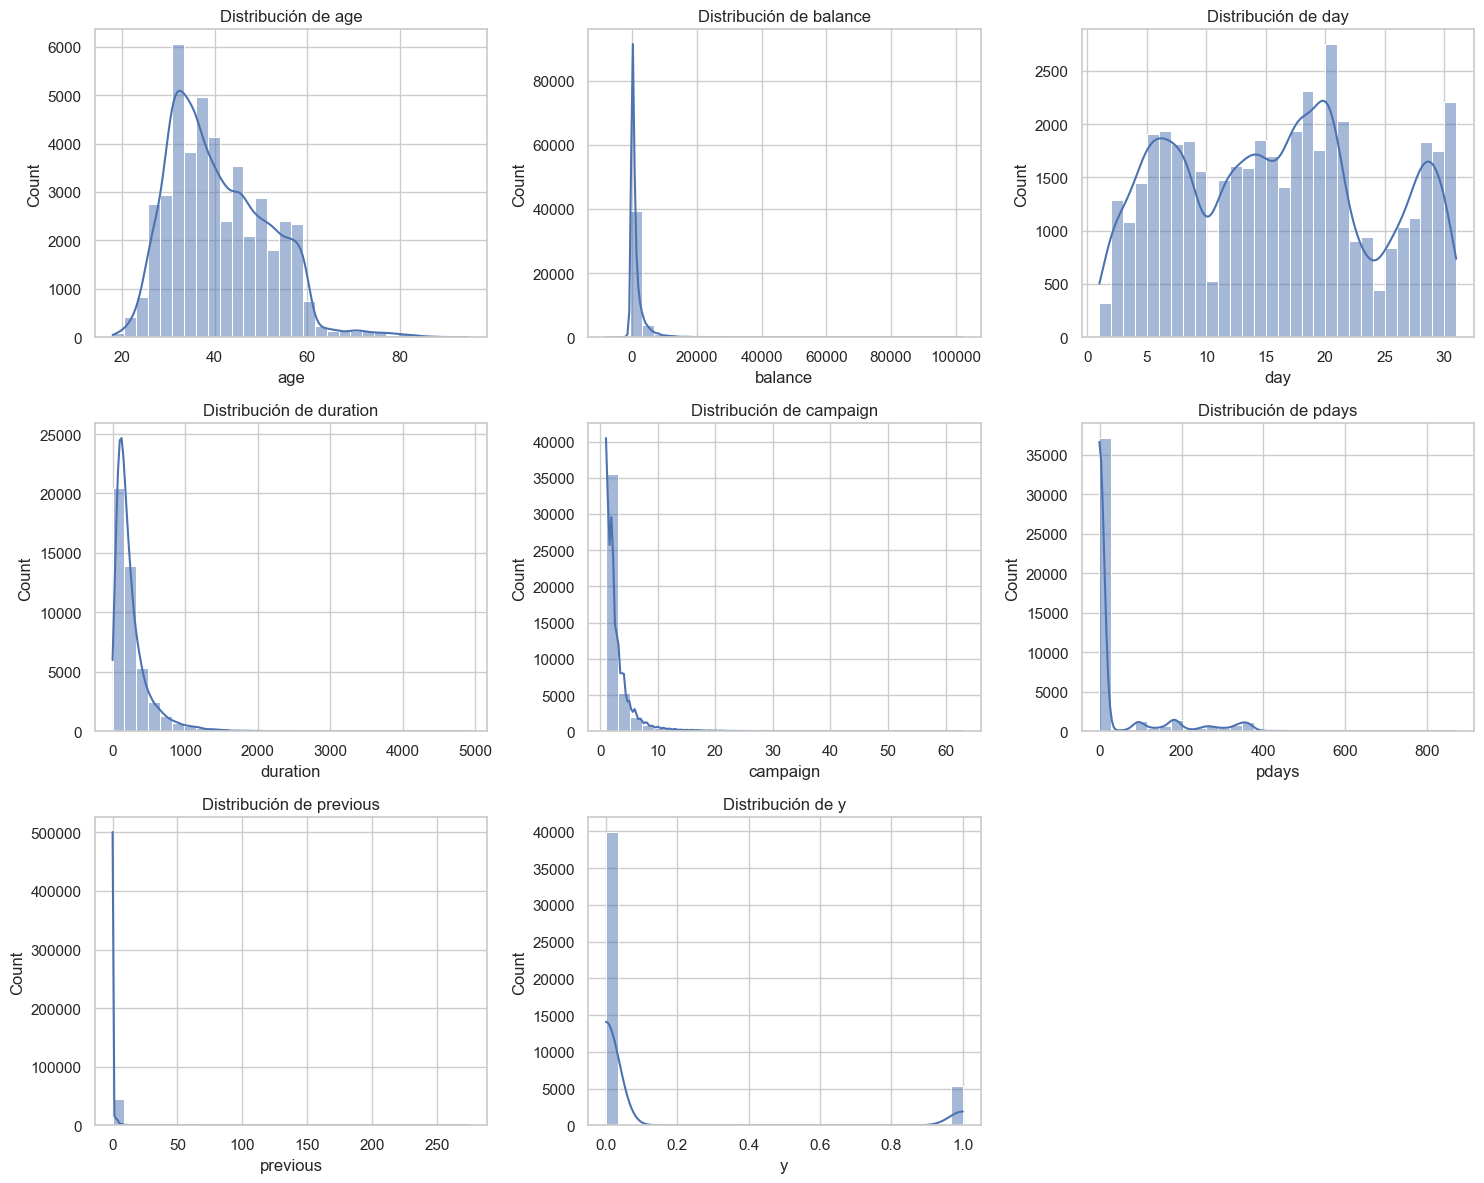

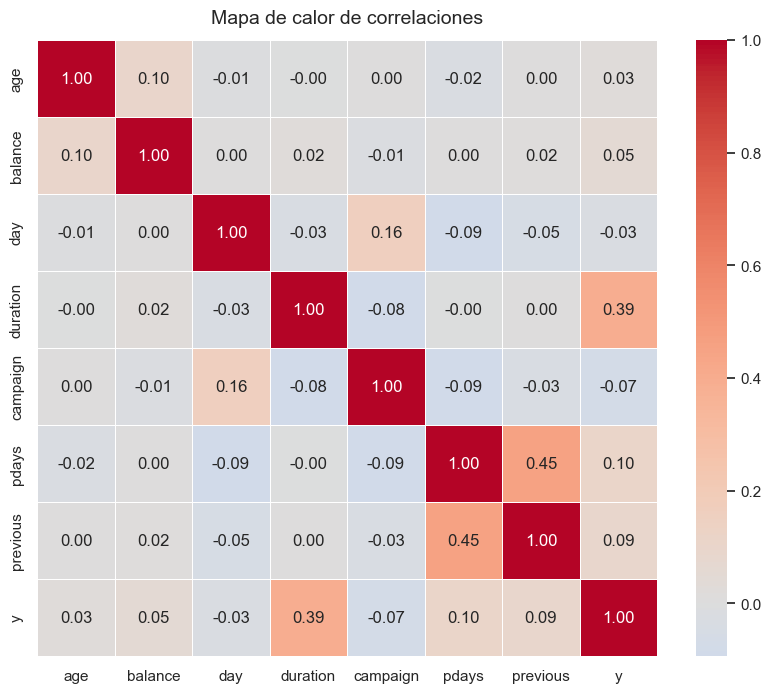

In [248]:
graph(df)

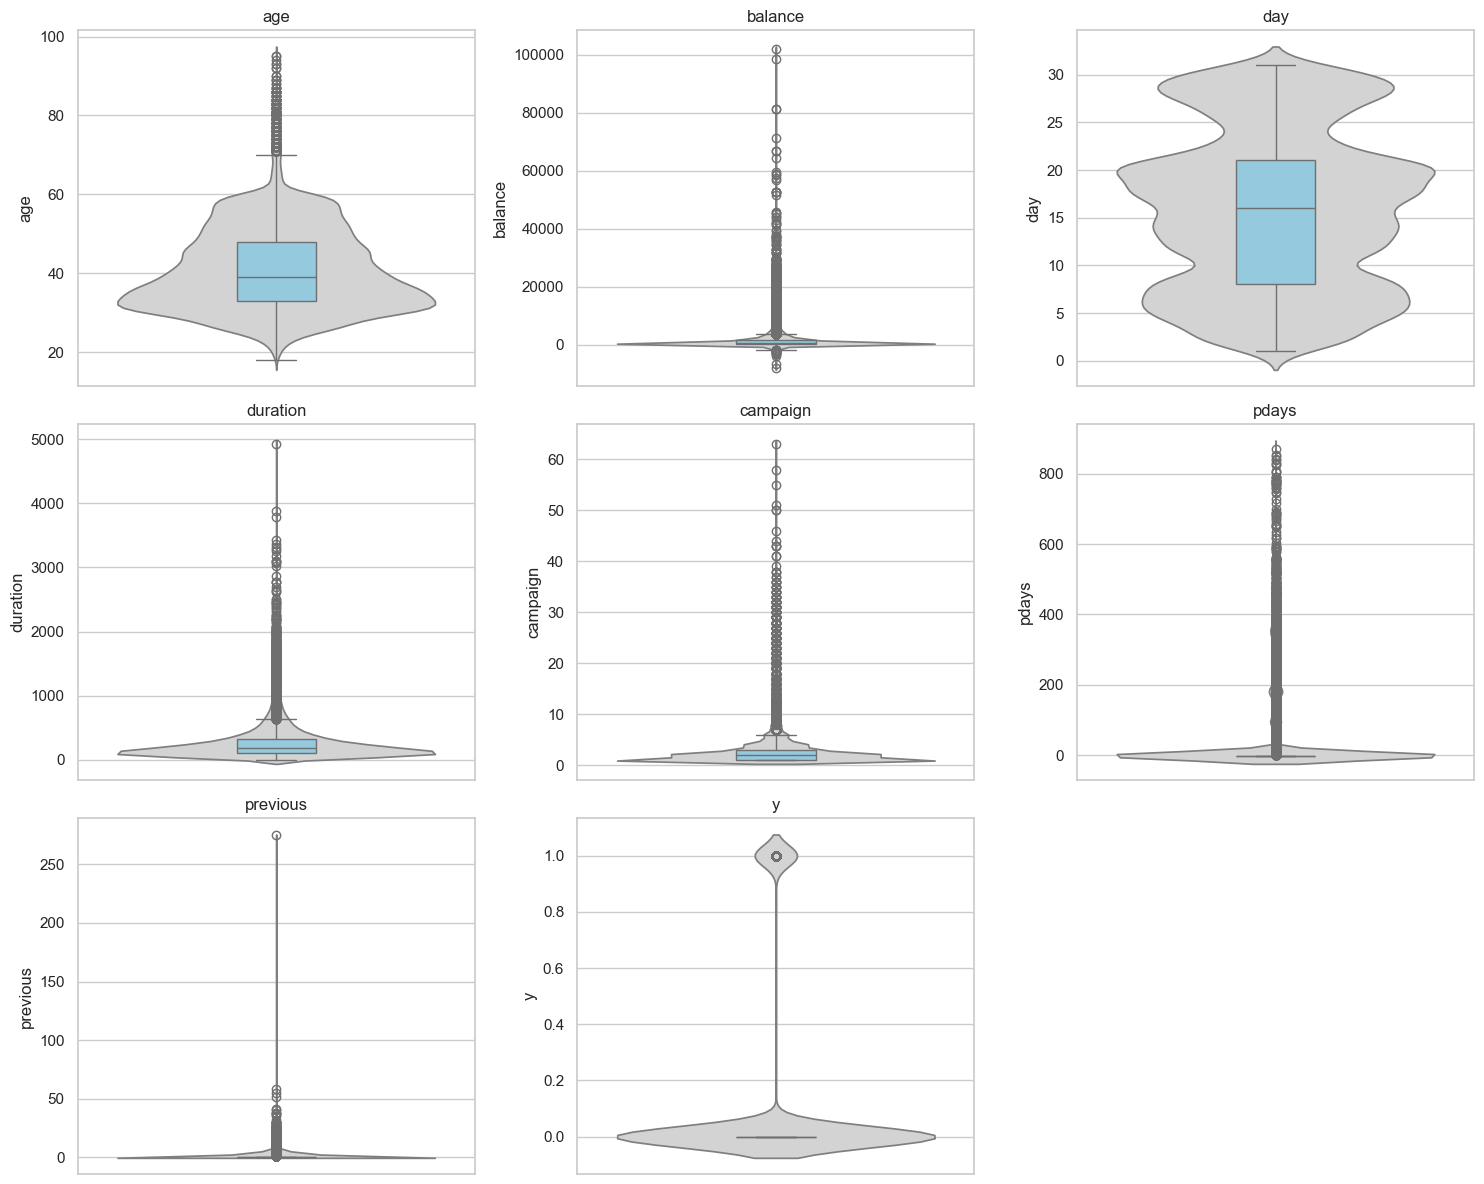

In [239]:
percent_box(df)

In [223]:
tot_promedio = df['y'].mean()

In [224]:
tot_promedio

np.float64(0.0)

In [17]:
X = df.drop(columns=['y'])
y = df[["y"]]


In [19]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


In [40]:
df_X.head(5)

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [49]:
feature_cols = [c for c in df.columns if c not in ['y']]
X = df[feature_cols].copy()
y = df['y'].values

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

logit = LogisticRegression(max_iter=2000, class_weight= 'balanced')

pipe = Pipeline([('pre', pre), ('clf', logit)])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cv = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:,1]

auc = roc_auc_score(y, proba_cv)
ap = average_precision_score(y, proba_cv)

auc, ap

(0.9095331898336185, 0.5446236789196289)

In [ ]:
def train_logit_cv_with_coefs(df, target='y', n_splits=5, random_state=42):

    feature_cols = [c for c in df.columns if c != target]
    X = df[feature_cols].copy()
    y = df[target].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])

    logit = LogisticRegression(
        max_iter=2000,
        class_weight='balanced'
    )

    pipe = Pipeline([
        ('pre', pre),
        ('clf', logit)
    ])

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    proba_cv = cross_val_predict(
        pipe, X, y, cv=cv, method='predict_proba'
    )[:, 1]

    auc = roc_auc_score(y, proba_cv)

    pipe.fit(X, y)
    feature_names = pipe.named_steps['pre'].get_feature_names_out()
    coefs = pipe.named_steps['clf'].coef_.ravel()
    coef_df = (
        pd.DataFrame({
            'feature': feature_names,
            'coef': coefs,
            'odds_ratio': np.exp(coefs)
        })
        .sort_values('odds_ratio', ascending=False)
        .reset_index(drop=True)
    )

    return {
        'auc': auc,
        'average_precision': ap,
        'coef_df': coef_df,
        'pipeline': pipe
    }


In [250]:
results = train_logit_cv_with_coefs(df)

results['auc'], results['average_precision']


(0.9095331898336185, 0.5446236789196289)

In [251]:
display(results['coef_df'].head(10)  )
display(results['coef_df'].tail(10)   )

,feature,coef,odds_ratio
0,cat__month_mar,1.838,6.282
1,cat__poutcome_success,1.816,6.147
2,num__duration,1.510,4.527
3,cat__month_oct,1.253,3.502
4,cat__month_sep,0.984,2.674
5,cat__job_student,0.704,2.023
6,cat__month_dec,0.659,1.933
7,cat__contact_cellular,0.546,1.726
8,cat__contact_telephone,0.506,1.658
9,cat__job_retired,0.471,1.602


,feature,coef,odds_ratio
41,cat__poutcome_other,-0.379,0.685
42,cat__housing_yes,-0.396,0.673
43,cat__poutcome_failure,-0.603,0.547
44,cat__month_may,-0.702,0.496
45,cat__poutcome_unknown,-0.844,0.430
46,cat__month_aug,-0.882,0.414
47,cat__month_nov,-0.958,0.384
48,cat__contact_unknown,-1.062,0.346
49,cat__month_jul,-1.062,0.346
50,cat__month_jan,-1.295,0.274


In [53]:
# Entrenamos el modelo final sobre todo el dataset para interpretar coeficientes
pipe.fit(X, y)

ohe = pipe.named_steps['pre'].named_transformers_['cat']
cat_feat_names = list(ohe.get_feature_names_out(cat_cols))
feat_names = num_cols + cat_feat_names
coefs = pipe.named_steps['clf'].coef_.ravel()

coef_df = (pd.DataFrame({'feature': feat_names,
                         'coef': coefs,
                         'odds_ratio': np.exp(coefs)})
           .sort_values('coef', ascending=False))

top_pos = coef_df.head(12).copy()
top_neg = coef_df.sort_values('coef', ascending=True).head(12).copy()

display(top_pos)
display(top_neg)


,feature,coef,odds_ratio
42,month_mar,1.837700,6.282074
49,poutcome_success,1.816004,6.147244
3,duration,1.510004,4.526750
45,month_oct,1.253217,3.501589
46,month_sep,0.983505,2.673810
15,job_student,0.704490,2.022814
37,month_dec,0.659323,1.933483
32,contact_cellular,0.545596,1.725636
33,contact_telephone,0.505509,1.657829
12,job_retired,0.470998,1.601591


,feature,coef,odds_ratio
39,month_jan,-1.295261,0.273826
40,month_jul,-1.061971,0.345774
34,contact_unknown,-1.061658,0.345882
44,month_nov,-0.958155,0.383600
36,month_aug,-0.881981,0.413962
50,poutcome_unknown,-0.844273,0.429870
43,month_may,-0.702150,0.495519
47,poutcome_failure,-0.603322,0.546992
29,housing_yes,-0.396272,0.672824
48,poutcome_other,-0.378962,0.684571


In [54]:
from xgboost import XGBClassifier

pre_xgb = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

pipe_xgb = Pipeline([
    ('pre', pre_xgb),
    ('clf', xgb)
])


In [ ]:


proba_xgb = cross_val_predict(
    pipe_xgb,
    X,
    y,
    cv=cv,
    method='predict_proba'
)[:, 1]

auc_xgb = roc_auc_score(y, proba_xgb)
ap_xgb  = average_precision_score(y, proba_xgb)

auc_xgb, ap_xgb


(0.93507331023611, 0.6300814637363884)

In [56]:
pipe_xgb.fit(X, y)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
X_enc = pipe_xgb.named_steps['pre'].transform(X)

# nombres de features
ohe = pipe_xgb.named_steps['pre'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_features)


In [58]:
import shap

explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
shap_values = explainer.shap_values(X_enc)


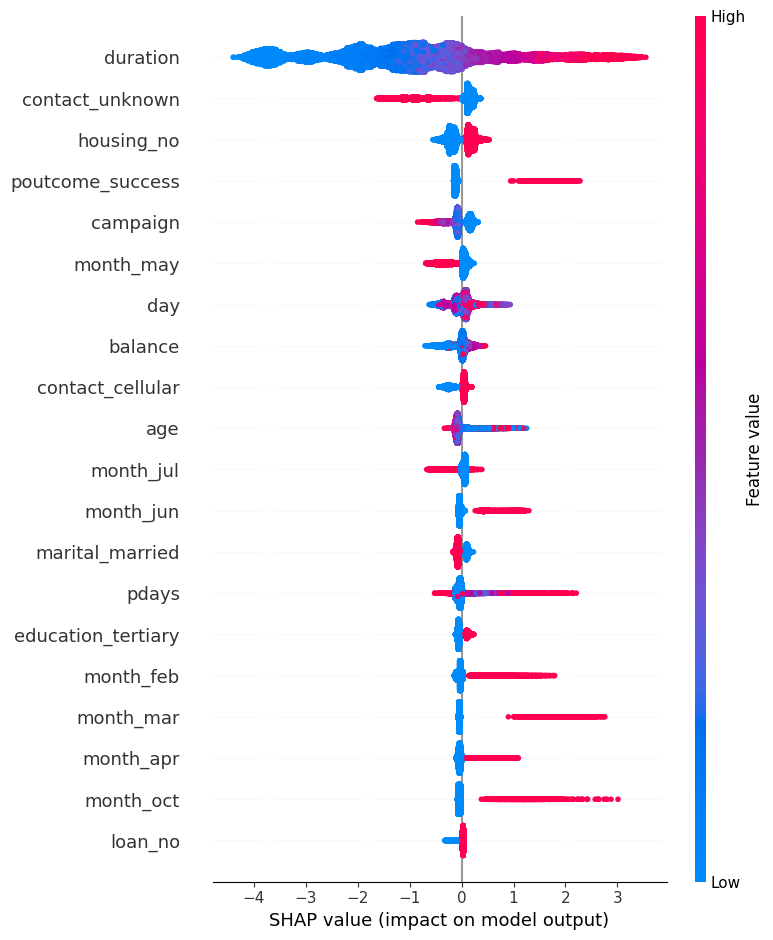

In [62]:
shap.summary_plot(
    shap_values,
    X_enc,
    feature_names=feature_names,
    sort= True,
    show=True
)


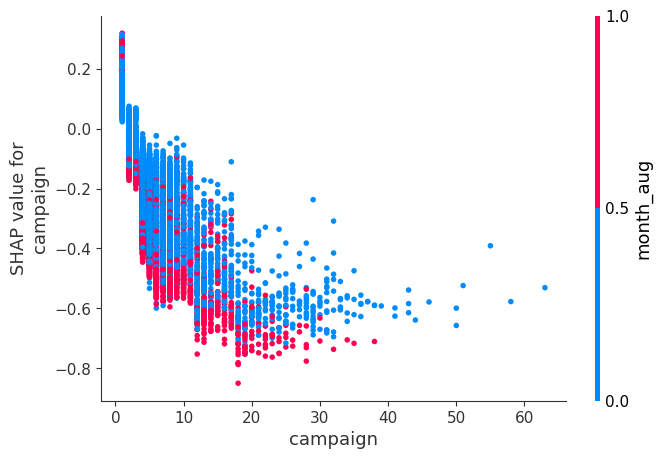

In [60]:
shap.dependence_plot(
    "campaign",
    shap_values,
    X_enc,
    feature_names=feature_names
)


In [ ]:
def add_oof_scores(pipe, X, y, cv=None, score_col="score_oof"):

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    proba_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]
    return proba_oof


def targeting_simulation(df, y_col, score_col, top_fracs=(0.10, 0.20, 0.30), n_calls=10000):

    baseline_rate = df[y_col].mean()

    out = []
    for frac in top_fracs:
        thr = df[score_col].quantile(1 - frac)
        seg = df[df[score_col] >= thr].copy()

        seg_rate = seg[y_col].mean()
        lift_vs_base = seg_rate / baseline_rate if baseline_rate > 0 else np.nan

        expected_sales_if_call = n_calls * seg_rate
        expected_sales_random = n_calls * baseline_rate

        out.append({
            "segment": f"Top {int(frac*100)}%",
            "threshold_score": thr,
            "segment_size": len(seg),
            "baseline_rate": baseline_rate,
            "segment_rate": seg_rate,
            "lift_x": lift_vs_base,
            "expected_sales_if_call_n": expected_sales_if_call,
            "expected_sales_random_n": expected_sales_random,
            "incremental_sales_n": expected_sales_if_call - expected_sales_random
        })

    return pd.DataFrame(out).sort_values("segment")



feature_cols = [c for c in df.columns if c not in ["y"]] 
X = df[feature_cols].copy()
y = df["y"].values 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_oof = add_oof_scores(pipe, X, y, cv=cv, score_col="score_oof")

auc = roc_auc_score(y, proba_oof)
ap = average_precision_score(y, proba_oof)
print(f"AUC(OOF)={auc:.3f} | AP(OOF)={ap:.3f}")

df_sim = df.copy()
df_sim["score_oof"] = proba_oof

summary = targeting_simulation(
    df=df_sim,
    y_col="y",
    score_col="score_oof",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000
)

pd.set_option("display.float_format", lambda v: f"{v:,.3f}")
display(summary[[
    "segment",
    "baseline_rate",
    "segment_rate",
    "lift_x",
    "expected_sales_if_call_n",
    "expected_sales_random_n",
    "incremental_sales_n"
]])

row = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
print(
    f"Baseline={row['baseline_rate']:.1%}. "
    f"Si priorizamos el {row['segment']} (score >= {row['threshold_score']:.3f}), "
    f"la conversión observada en ese segmento es {row['segment_rate']:.1%} "
    f"(lift x{row['lift_x']:.2f})."
)


AUC(OOF)=0.910 | AP(OOF)=0.545


,segment,baseline_rate,segment_rate,lift_x,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.117,0.590,5.040,"5,895.621","1,169.848","4,725.773"
1,Top 20%,0.117,0.451,3.857,"4,511.777","1,169.848","3,341.929"
2,Top 30%,0.117,0.349,2.981,"3,487.172","1,169.848","2,317.324"


Baseline=11.7%. Si priorizamos el Top 10% (score >= 0.833), la conversión observada en ese segmento es 59.0% (lift x5.04).


In [90]:
df_sim

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,score_oof,is_top10
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,0.076,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,0.044,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,0.010,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,0.022,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,0.095,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1,0.976,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1,0.707,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,0.999,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0,0.588,0


In [85]:
threshold = 0.833

df_sim["is_top10"] = (df_sim["score_oof"] >= threshold).astype(int)

df_top = df_sim[df_sim["is_top10"] == 1]
df_all = df_sim.copy()


In [103]:
def profile_categorical(df_all, df_seg, col, top_k=10):
    base_dist = (
        df_all[col]
        .value_counts(normalize=True)
        .rename("base_pct")
    )
    
    seg_dist = (
        df_seg[col]
        .value_counts(normalize=True)
        .rename("segment_pct")
    )
    
    out = (
        pd.concat([base_dist, seg_dist], axis=1)
        .fillna(0)
        .assign(
            diff_pct=lambda x: x["segment_pct"] - x["base_pct"],
            lift=lambda x: np.where(
                x["base_pct"] > 0,
                x["segment_pct"] / x["base_pct"],
                np.nan
            )
        )
        .sort_values("lift", ascending=False)
        .head(top_k)
    )
    
    return out


In [104]:
profile_categorical(df_all, df_top, "contact")

,base_pct,segment_pct,diff_pct,lift
contact,,,,
cellular,0.648,0.842,0.195,1.300
telephone,0.064,0.079,0.015,1.235
unknown,0.288,0.078,-0.210,0.272


In [105]:
profile_categorical(df_all, df_top, "poutcome")

,base_pct,segment_pct,diff_pct,lift
poutcome,,,,
success,0.033,0.272,0.238,8.129
other,0.041,0.065,0.024,1.588
failure,0.108,0.107,-0.001,0.987
unknown,0.817,0.557,-0.261,0.681


In [106]:
profile_categorical(df_all, df_top, "month")

,base_pct,segment_pct,diff_pct,lift
month,,,,
mar,0.011,0.071,0.060,6.709
dec,0.005,0.026,0.022,5.544
oct,0.016,0.090,0.074,5.512
sep,0.013,0.071,0.058,5.510
apr,0.065,0.111,0.046,1.714
feb,0.059,0.084,0.025,1.430
nov,0.088,0.075,-0.013,0.851
jan,0.031,0.026,-0.005,0.846
aug,0.138,0.109,-0.029,0.787


In [87]:
profile_categorical(df_all, df_top, "month")
profile_categorical(df_all, df_top, "poutcome")
profile_categorical(df_all, df_top, "contact")
profile_categorical(df_all, df_top, "job")


,base_pct,segment_pct,diff_pct,lift
job,,,,
retired,0.050,0.115,0.065,2.294
student,0.021,0.065,0.044,3.125
management,0.209,0.248,0.038,1.184
unemployed,0.029,0.046,0.017,1.599
admin.,0.114,0.117,0.002,1.022
self-employed,0.035,0.037,0.002,1.061
unknown,0.006,0.006,-0.000,0.969
housemaid,0.027,0.021,-0.007,0.748
entrepreneur,0.033,0.022,-0.011,0.657


In [88]:
def profile_numeric(df_all, df_seg, col):
    return pd.DataFrame({
        "base_mean": [df_all[col].mean()],
        "segment_mean": [df_seg[col].mean()],
        "base_median": [df_all[col].median()],
        "segment_median": [df_seg[col].median()],
        "diff_mean": [df_seg[col].mean() - df_all[col].mean()]
    }, index=[col])


In [89]:
profile_numeric(df_all, df_top, "campaign")
profile_numeric(df_all, df_top, "balance")
profile_numeric(df_all, df_top, "age")


,base_mean,segment_mean,base_median,segment_median,diff_mean
age,40.936,42.180,39.000,39.000,1.244
